In [3]:
from pathlib import Path
import re

import matplotlib.animation as anim
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import scipy.stats as st
import seaborn as sns

In [4]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [5]:
study_models = [
    "librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames",
    "librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames",
    "librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/syllable_10frames",
    # "librispeech-train-clean-100/w2v2_8/rnn_32-hinge_ph-mAP1/phoneme_10frames",
    # "librispeech-train-clean-100/w2v2_8/rnn_32-hinge_ph-mAP2/phoneme_10frames",
    # "librispeech-train-clean-100/w2v2_8/rnn_32-hinge_ph-mAP3/phoneme_10frames",
    # "librispeech-train-clean-100/w2v2_8/rnn_32-hinge_ph-mAP4/phoneme_10frames",
    # "librispeech-train-clean-100/w2v2_8/rnn_32-hinge_ph-mAP5/phoneme_10frames",
    "librispeech-train-clean-100/w2v2_8/randomrnn_32/random",
]

In [6]:
frames = {}
for study_model in study_models:
    frames_i = list(Path(f"outputs/notebooks/{study_model}/rsa_phoneme/").glob("*.png"))
    frames_i = {int(re.search(r"(\d+).png", str(f)).group(1)): f for f in frames_i}
    frames[study_model] = frames_i

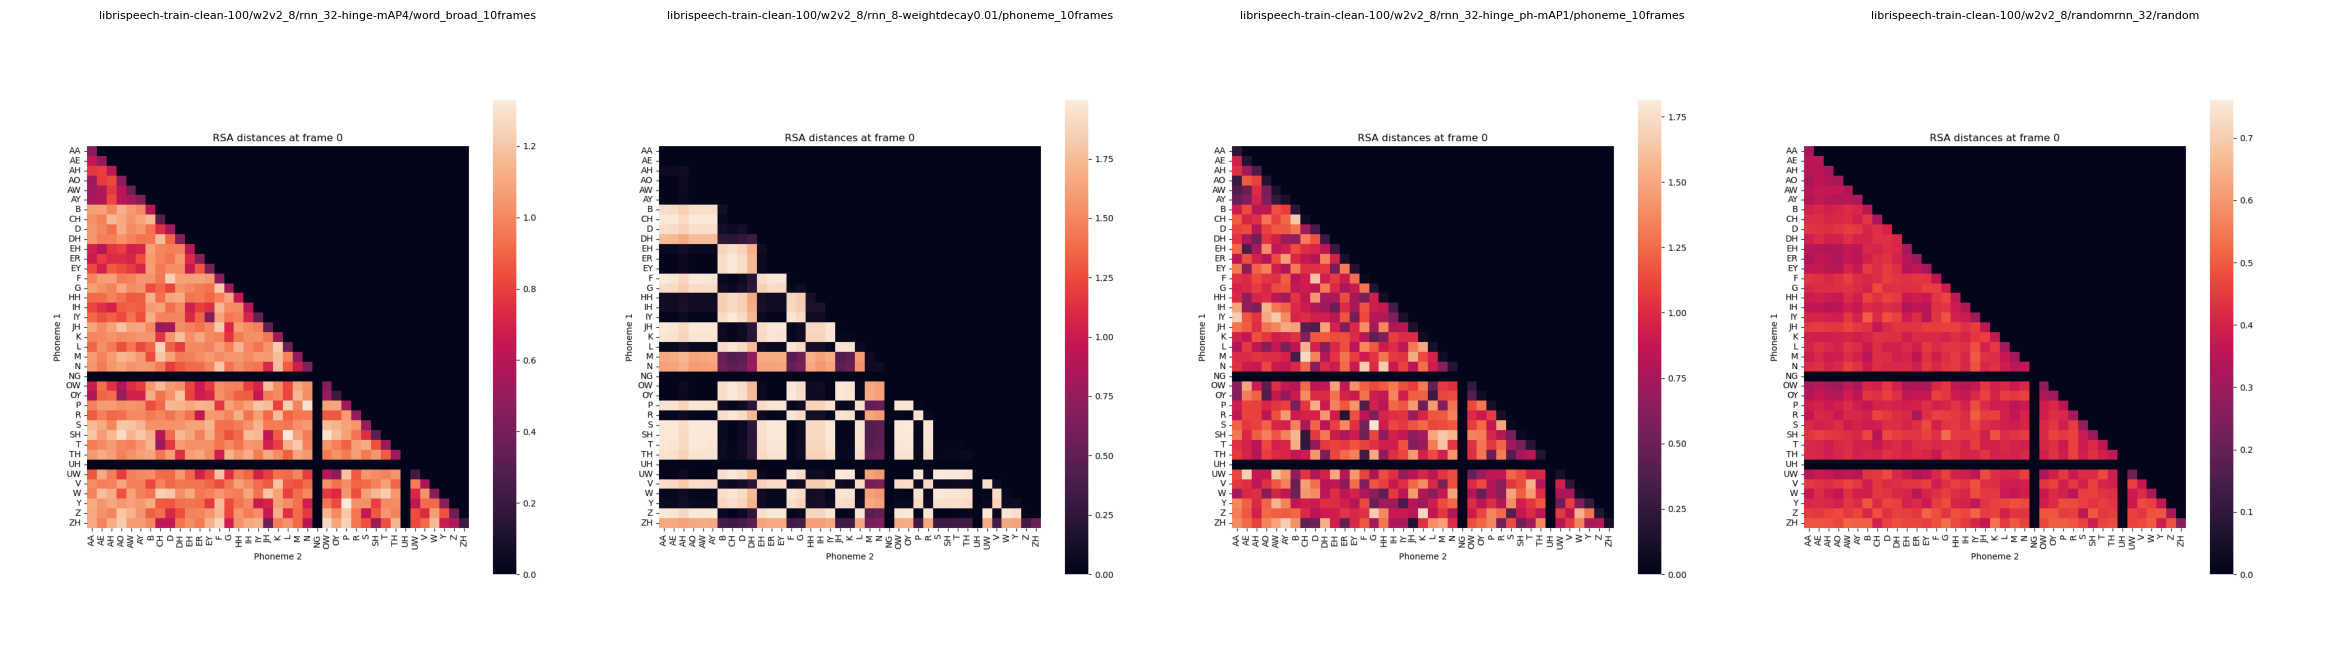

In [7]:
f, axs = plt.subplots(1, len(frames), figsize=(8 * len(frames), 8))
# reduce spacing
plt.subplots_adjust(wspace=-0.25, hspace=0)
for study_model, ax in zip(frames, axs.flat):
    ax.axis("off")
    ax.set_title(study_model, fontsize=8)

def animate(i):
    for study_model, ax in zip(frames, axs.flat):
        im = plt.imread(frames[study_model][i])
        ax.imshow(im)

num_frames = len(frames[study_models[0]])
ani = anim.FuncAnimation(f, animate, frames=num_frames, interval=100)
ani.save("summary_notebooks/rsa_phoneme.gif", writer="imagemagick", fps=2)

## Quantitative comparison of RSA matrices

In [9]:
rsa_mats = {}
rsa_path_template = "outputs/notebooks/{}/rsa_phoneme/rsa_results.csv"
phoneme_order = list(pd.read_csv(rsa_path_template.format(study_models[0]), index_col=[0, 1]).loc[0].index)
print(" ".join(phoneme_order))

# keep track of phoneme*frame combinations which are unattested
unattested_phoneme_frames = {}

for study_model in study_models:
    rsa_i = pd.read_csv(rsa_path_template.format(study_model), index_col=[0, 1])
    for frame_idx, rsa_ij in rsa_i.groupby("frame_idx"):
        assert (rsa_ij.index.get_level_values(1) == phoneme_order).all()
        rsa_mats[study_model, frame_idx] = rsa_ij.values

        # find columns which are wholly unattested
        unattested_ij = set(np.isclose(rsa_ij.values, 0).all(axis=0).nonzero()[0])
        if frame_idx not in unattested_phoneme_frames:
            unattested_phoneme_frames[frame_idx] = unattested_ij
        else:
            unattested_phoneme_frames[frame_idx] &= unattested_ij

        rsa_mats_tril[study_model, frame_idx] = rsa_ij.values[np.tril_indices(len(phoneme_order))]

AA AE AH AO AW AY B CH D DH EH ER EY F G HH IH IY JH K L M N NG OW OY P R S SH T TH UH UW V W Y Z ZH


NameError: name 'rsa_mats_tril' is not defined

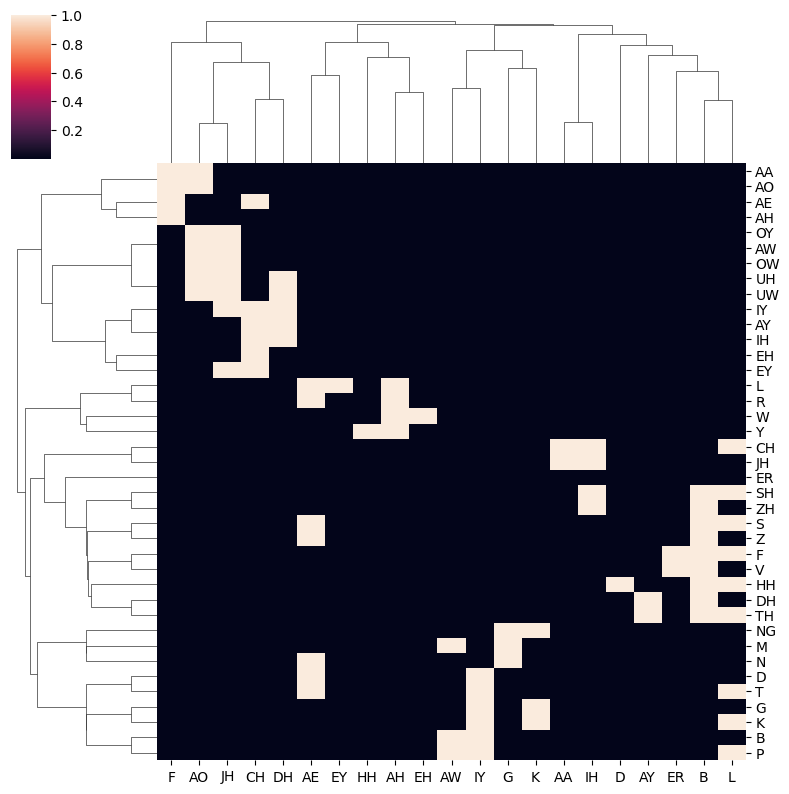

In [10]:
# Define features for each phoneme
cmudict_features = {
    "AA": "low back",
    "AE": "low front",
    "AH": "low",
    "AO": "low back",
    "AW": "back rounded",
    "AY": "high front",
    "B": "bilabial plosive",
    "CH": "voiceless palato-alveolar affricate",
    "D": "alveolar plosive",
    "DH": "dental fricative",
    "EH": "front",
    "ER": "",
    "EY": "front rounded",
    "F": "voiceless labiodental fricative",
    "G": "velar plosive",
    "HH": "voiceless glottal fricative",
    "IH": "high front",
    "IY": "high front rounded",
    "JH": "palato-alveolar affricate",
    "K": "voiceless velar plosive",
    "L": "alveolar lateral approximant",
    "M": "bilabial nasal",
    "N": "alveolar nasal",
    "NG": "velar nasal",
    "OW": "back rounded",
    "OY": "back rounded",
    "P": "voiceless bilabial plosive",
    "R": "alveolar approximant",
    "S": "voiceless alveolar fricative",
    "SH": "voiceless palato-alveolar fricative",
    "T": "voiceless alveolar plosive",
    "TH": "voiceless dental fricative",
    "UH": "high back rounded",
    "UW": "high back rounded",
    "V": "labiodental fricative",
    "W": "labio-velar approximant",
    "Y": "palatal approximant",
    "Z": "alveolar fricative",
    "ZH": "palato-alveolar fricative",
}
cmudict_features = {k: v.split() for k, v in cmudict_features.items()}
assert set(cmudict_features.keys()) == set(phoneme_order)
all_features = sorted(set([f for v in cmudict_features.values() for f in v]))
feature_matrix = np.zeros((len(cmudict_features), len(all_features)), dtype=int) + 0.001
for i, (phoneme, features) in enumerate(cmudict_features.items()):
    for feature in features:
        j = all_features.index(feature)
        feature_matrix[i, j] = 1

# Convert to a DataFrame
feature_matrix = pd.DataFrame(feature_matrix, index=phoneme_order, columns=all_features)
distance_matrix = squareform(pdist(feature_matrix, metric="cosine"))
static_distances = {"featural": distance_matrix}

sns.clustermap(feature_matrix, yticklabels=phoneme_order, xticklabels=phoneme_order, metric="cosine", figsize=(8, 8))

In [11]:
frame_idxs = sorted(set(frame_idx for _, frame_idx in rsa_mats))

# create a mask to extract lower triangle of RSA matrices (including diagonal),
# excluding phonemes which are unattested
tril_masks = {}
for frame_idx in frame_idxs:
    mask = np.zeros((len(phoneme_order), len(phoneme_order)), dtype=bool)
    mask[np.tril_indices(len(phoneme_order))] = True
    mask[list(unattested_phoneme_frames[frame_idx]), :] = False
    mask[:, list(unattested_phoneme_frames[frame_idx])] = False
    tril_masks[frame_idx] = mask

# store extracted subsets of lower triangle
rsa_mats_tril = {(study_model, frame_idx): rsa_mat[tril_masks[frame_idx]]
                 for (study_model, frame_idx), rsa_mat in rsa_mats.items()}

In [12]:
# stack within frame
rsa_mats_tril_stacked = {
    frame_idx: np.stack([rsa_mats_tril[study_model, frame_idx]
                         for study_model in study_models])
    for frame_idx in frame_idxs}

# drop frames with not enough phoneme pair data
rsa_mats_tril_stacked = {frame_idx: rsa_mat
                         for frame_idx, rsa_mat in rsa_mats_tril_stacked.items()
                         if rsa_mat.shape[1] >= (12 - 1) ** 2}

KeyError: ('librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25', 0)

In [13]:
# add in static distance matrices
for name, sim in static_distances.items():
    for frame_idx in rsa_mats_tril_stacked:
        rsa_mats_tril_stacked[frame_idx] = np.concatenate([rsa_mats_tril_stacked[frame_idx], sim[tril_masks[frame_idx]][None, :]])

all_models = list(study_models) + list(static_distances.keys())

NameError: name 'rsa_mats_tril_stacked' is not defined

In [236]:
reference_model = "featural"
reference_model = study_models[1]
reference_model_idx = all_models.index(reference_model)
reference_model

'librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames'

In [237]:
rsa_sims = {
    frame_idx: [st.spearmanr(tril_stacked_i[model_idx],
                            tril_stacked_i[reference_model_idx])[0]
                for model_idx, _ in enumerate(all_models)]
    for frame_idx, tril_stacked_i in rsa_mats_tril_stacked.items()
}

In [259]:
rsa_sims_df = pd.DataFrame(rsa_sims, index=all_models).reset_index().melt(
    id_vars="index", var_name="frame_idx", value_name="similarity")
rsa_sims_df = rsa_sims_df.set_index(["index", "frame_idx"]).sort_index()
rsa_sims_df["similarity_delta"] = rsa_sims_df.similarity - rsa_sims_df.groupby("index").similarity.head(1).droplevel(-1)
rsa_sims_df

similarity  \
index                                              frame_idx               
featural                                           0            0.398991   
                                                   1            0.433807   
                                                   2            0.428796   
                                                   3            0.458310   
                                                   4            0.467121   
...                                                                  ...   
librispeech-train-clean-100/w2v2_8/rnn_8-weight... 8            0.078639   
                                                   9            0.075824   
                                                   10           0.331281   
                                                   11           0.382783   
                                                   12           0.308233   

                                                              similarity_delta  
index                                              frame_idx                    
featural                                           0                  0.000000  
                                                   1                  0.034817  
                                                   2                  0.029805  
                                                   3                  0.059320  
                                                   4                  0.068130  
...                                                                        ...  
librispeech-train-clean-100/w2v2_8/rnn_8-weight... 8                 -0.735865  
                                                   9                 -0.738679  
                                                   10                -0.483222  
                                                   11                -0.431720  
                                                   12                -0.506271  

[65 rows x 2 columns]

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 1.0, 'Within-frame, between-model phoneme RSA similiarity')

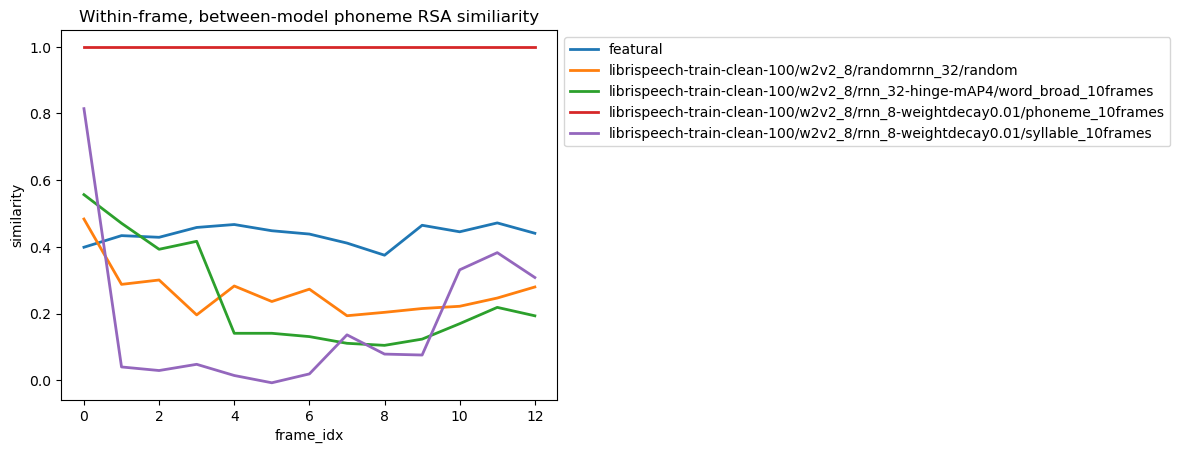

In [263]:
ax = sns.lineplot(data=rsa_sims_df.reset_index(), x="frame_idx", y="similarity", hue="index", linewidth=2)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("Within-frame, between-model phoneme RSA similiarity")

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 1.0, 'Within-frame, between-model change in phoneme RSA similarity')

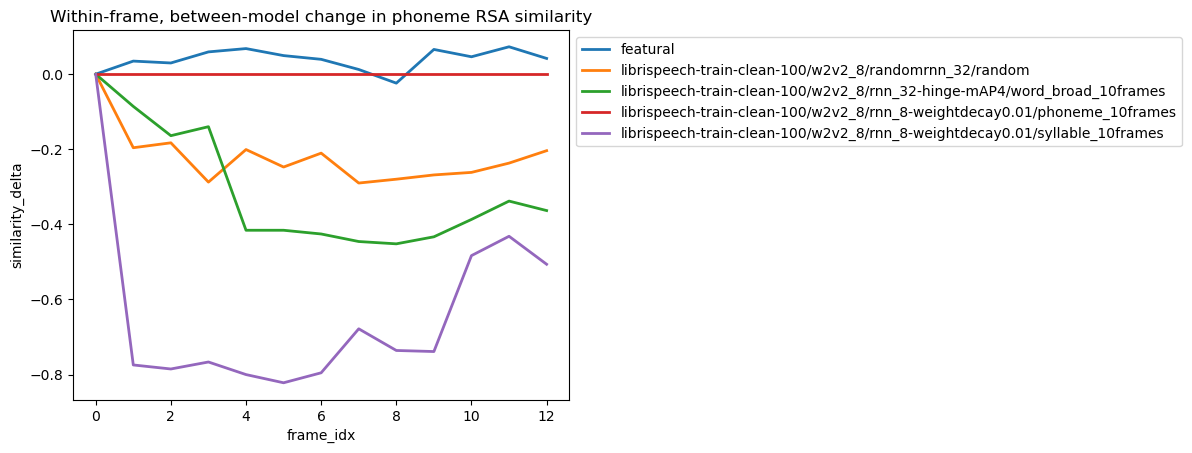

In [262]:
ax = sns.lineplot(data=rsa_sims_df.reset_index(), x="frame_idx", y="similarity_delta", hue="index", linewidth=2)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("Within-frame, between-model change in phoneme RSA similarity")

In [266]:
study_models

['librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames',
 'librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames',
 'librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/syllable_10frames',
 'librispeech-train-clean-100/w2v2_8/randomrnn_32/random']

Text(0.5, 0.98, 'librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames')

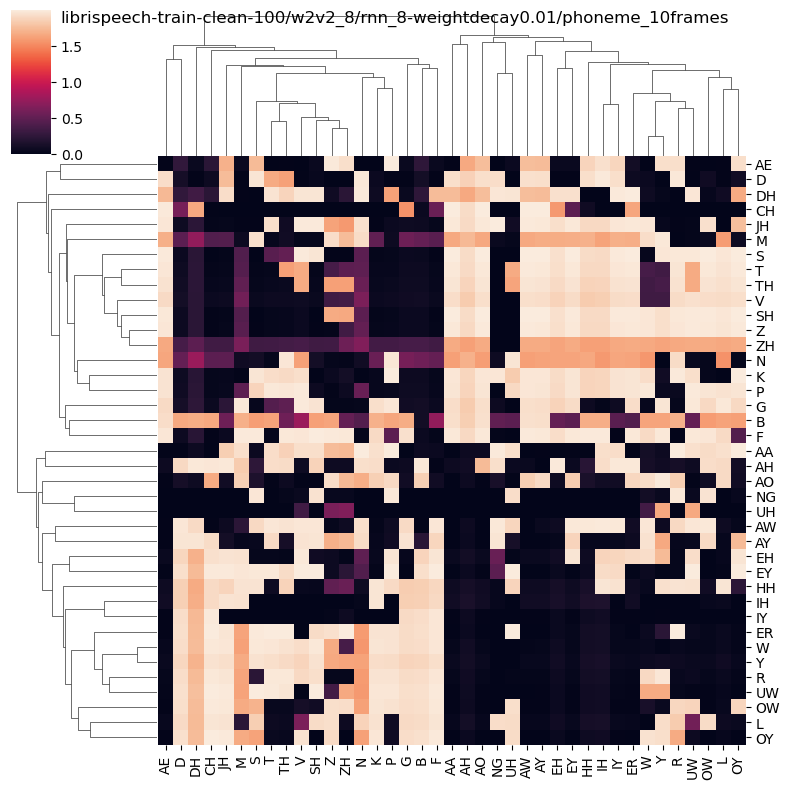

In [301]:
clustermap_model = study_models[1]
dev = rsa_mats[clustermap_model, 0].copy()
dev[np.triu_indices(len(phoneme_order), 1)] = dev[np.tril_indices(len(phoneme_order), -1)]
from scipy.cluster.hierarchy import linkage
dev_linkage = linkage(dev, method="average")
g = sns.clustermap(dev, row_linkage=dev_linkage, col_linkage=dev_linkage,
                   xticklabels=phoneme_order, yticklabels=phoneme_order, figsize=(8, 8))
g.fig.suptitle(clustermap_model)